# SEGUIMIENTO DE AUTOS

## Tecnicas clasicas

🔄 Procesando hasta 210 frames (~30 segundos)...
🧠 Aprendiendo fondo... Frame 50/210
🧠 Aprendiendo fondo... Frame 100/210
🧠 Aprendiendo fondo... Frame 150/210
🧠 Aprendiendo fondo... Frame 200/210


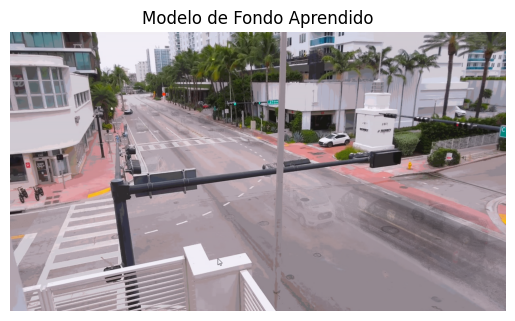

✅ Fondo guardado en: modelo_fondo.png


In [32]:
import cv2
import os
import matplotlib.pyplot as plt


def extract_background(video_path, output_image_path="background_model.png",
                       history=500, var_threshold=16, detect_shadows=True, duration=30):
    """
    Aprende el fondo de un video y guarda la imagen del fondo.
    
    Args:
        video_path (str): Ruta del video.
        output_image_path (str): Ruta donde guardar la imagen del fondo.
        history (int): Historial para MOG2.
        var_threshold (int): Umbral de varianza.
        detect_shadows (bool): Si detecta sombras.
        duration (int): Duración en segundos para procesar.
    """
    
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"No se encontró el video: {video_path}")

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    max_frames = int(fps * duration)

    fgbg = cv2.createBackgroundSubtractorMOG2(
        history=history,
        varThreshold=var_threshold,
        detectShadows=detect_shadows
    )

    frame_count = 0
    print(f"🔄 Procesando hasta {max_frames} frames (~{duration} segundos)...")

    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            print("📌 Fin del video antes del límite.")
            break

        fgbg.apply(frame)  # Actualizar modelo de fondo

        frame_count += 1
        if frame_count % 50 == 0:
            print(f"🧠 Aprendiendo fondo... Frame {frame_count}/{max_frames}")

    # Obtener el modelo de fondo
    bg_model = fgbg.getBackgroundImage()

    if bg_model is None:
        print("⚠️ No se pudo obtener el modelo de fondo. Procesa más frames.")
        cap.release()
        return

    # Mostrar el modelo de fondo
    plt.imshow(cv2.cvtColor(bg_model, cv2.COLOR_BGR2RGB))
    plt.title("Modelo de Fondo Aprendido")
    plt.axis('off')
    plt.show()

    # Guardar la imagen del fondo
    cv2.imwrite(output_image_path, bg_model)
    print(f"✅ Fondo guardado en: {output_image_path}")

    cap.release()


# ===============================
# 🚀 Ejecutar
# ===============================

if __name__ == "__main__":
    video_file = "carito.mp4"  # 🔗 Cambia esto por tu video
    output_image = "modelo_fondo.png"

    extract_background(
        video_path=video_file,
        output_image_path=output_image,
        history=500,
        var_threshold=16,
        detect_shadows=True,
        duration=30  # Procesar 30 segundos
    )


## DETECCIÓN DE MOVIMIENTO

In [30]:
import cv2
import numpy as np
import os
import time
import pickle
import matplotlib.pyplot as plt
from tracker import CentroidTracker  # Asumiendo que lo guardaste en tracker.py


def create_background_subtractor(history=500, varThreshold=16, detectShadows=True):
    return cv2.createBackgroundSubtractorMOG2(
        history=history,
        varThreshold=varThreshold,
        detectShadows=detectShadows
    )



def show_frame_visualization(frame, fgmask, bg_model, frame_count, fps, detect_shadows):
    """Muestra una visualización de los resultados cada cierto intervalo."""
    current_time = frame_count / fps
    minutes = int(current_time // 60)
    seconds = int(current_time % 60)

    plt.figure(figsize=(16, 10))

    plt.subplot(221)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f'Original - Tiempo: {minutes:02d}:{seconds:02d}')
    plt.axis('off')

    plt.subplot(222)
    if bg_model is not None:
        plt.imshow(cv2.cvtColor(bg_model, cv2.COLOR_BGR2RGB))
        plt.title('Modelo de Fondo')
    else:
        plt.title('Modelo de Fondo no disponible')
    plt.axis('off')

    plt.subplot(223)
    plt.imshow(fgmask, cmap='gray')
    plt.title('Máscara con sombras')
    plt.axis('off')

    plt.subplot(224)
    if detect_shadows:
        binary_mask = np.where(fgmask == 255, 255, 0).astype(np.uint8)
    else:
        binary_mask = fgmask
    plt.imshow(binary_mask, cmap='gray')
    plt.title('Máscara Binaria sin sombras')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


def save_background_model(model_path, bg_model, parameters):
    """Guarda el modelo de fondo y parámetros en un archivo pickle."""
    os.makedirs(os.path.dirname(model_path) or ".", exist_ok=True)
    data = {'bg_model': bg_model, 'parameters': parameters}
    with open(model_path, 'wb') as f:
        pickle.dump(data, f)
    print(f"✅ Modelo guardado en: {model_path}")


def load_background_model(model_path):
    """Carga el modelo de fondo desde un archivo."""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"No se encontró el modelo: {model_path}")
    with open(model_path, 'rb') as f:
        return pickle.load(f)


def background_subtraction_mog2(video_path, duration=30, display_interval=30,
                                history=500, var_threshold=16, detect_shadows=True,
                                save_model=False, model_path=None, load_model=False):
    """Realiza sustracción de fondo sobre un video usando MOG2."""
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"No se encontró el video: {video_path}")

    video_name = os.path.splitext(os.path.basename(video_path))[0]
    model_path = model_path or f"bg_model_{video_name}_h{history}_vt{var_threshold}.pkl"

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    max_frames = int(fps * duration)

    print(f"🔄 Procesando {max_frames} frames (~{duration}s a {fps:.2f} FPS)...")

    fgbg = create_background_subtractor(history, var_threshold, detect_shadows)

    if load_model:
        try:
            model_data = load_background_model(model_path)
            bg_model = model_data['bg_model']
            print(f"✅ Modelo cargado desde: {model_path}")
        except Exception as e:
            print(f"⚠️ Error al cargar modelo: {e}. Usando modelo nuevo.")
            bg_model = None
    else:
        bg_model = None

    frame_count = 0
    start_time = time.time()

    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            print("📌 Fin del video.")
            break

        fgmask = fgbg.apply(frame)
        bg_model = fgbg.getBackgroundImage()

        if frame_count % display_interval == 0:
            show_frame_visualization(frame, fgmask, bg_model, frame_count, fps, detect_shadows)
            elapsed = time.time() - start_time
            print(f"🧮 Frame {frame_count}/{max_frames} | Tiempo: {elapsed:.2f}s | Velocidad: {frame_count/elapsed:.2f} FPS")

        frame_count += 1

    cap.release()

    if save_model and bg_model is not None:
        save_background_model(model_path, bg_model, {
            'history': history,
            'varThreshold': var_threshold,
            'detectShadows': detect_shadows
        })

    print(f"\n✅ Proceso completado: {frame_count} frames en {time.time() - start_time:.2f}s")
    return bg_model


def apply_background_model(video_path, model_path, duration=30, display_interval=30, output_path=None):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Modelo no encontrado: {model_path}")

    model_data = load_background_model(model_path)
    parameters = model_data['parameters']
    fgbg = create_background_subtractor(**parameters)

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    max_frames = int(fps * duration)

    tracker = CentroidTracker()

    # Inicializar escritor de video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_path = output_path or "output_tracking.mp4"
    out_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        fgmask = fgbg.apply(frame)
        refined_mask = refine_mask(fgmask)
        features = extract_features(refined_mask, frame)

        # Extrae centroides
        input_centroids = np.array([f['centroid'] for f in features], dtype="int")
        objects = tracker.update(input_centroids)

        result = frame.copy()

        # Dibujar bounding boxes e IDs
        for obj, feature in zip(objects.items(), features):
            object_id, centroid = obj
            x, y, w, h = feature['bounding_box']
            cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(result, f"ID {object_id}", (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
            cv2.circle(result, centroid, 4, (0, 0, 255), -1)

        # Escribir frame en el video de salida
        out_writer.write(result)

        if frame_count % display_interval == 0:
            # Mostrar resultados solo en consola
            print(f"📹 Frame {frame_count}/{max_frames} procesado...")

        frame_count += 1

    cap.release()
    out_writer.release()
    print(f"✅ Seguimiento completado. Video exportado en: {output_path}")

    
def refine_mask(fgmask, shadow_val=127, min_area=500):
    """Procesa la máscara para eliminar sombras, reducir ruido y unir objetos."""
    # Eliminar sombras (valores 127) → quedarnos con objetos reales
    binary_mask = np.where(fgmask == 255, 255, 0).astype(np.uint8)

    # Operaciones morfológicas: apertura (ruido), cierre (agujeros), dilatación (unión)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    clean = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel)
    clean = cv2.dilate(clean, kernel, iterations=1)

    # Filtrado por área mínima
    contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_mask = np.zeros_like(clean)
    for cnt in contours:
        if cv2.contourArea(cnt) >= min_area:
            cv2.drawContours(final_mask, [cnt], -1, 255, -1)

    return final_mask


def extract_features(mask, frame):
    """Extrae características de objetos detectados en la máscara."""
    features = []
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 100:  # ignorar objetos muy pequeños
            continue

        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        cx = x + w // 2
        cy = y + h // 2

        obj_features = {
            'area': area,
            'centroid': (cx, cy),
            'bounding_box': (x, y, w, h),
            'aspect_ratio': aspect_ratio
        }

        features.append(obj_features)
    return features

def background_subtraction_mog2_with_export(video_path, duration=30, display_interval=30,
                                            history=500, var_threshold=16, detect_shadows=True,
                                            output_path="output_online_tracking.mp4"):
    """Realiza sustracción de fondo y exporta video con detección y seguimiento en línea."""
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"No se encontró el video: {video_path}")

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    max_frames = int(fps * duration)

    # Crear sustractor y tracker
    fgbg = create_background_subtractor(history, var_threshold, detect_shadows)
    tracker = CentroidTracker()

    # Inicializar escritor de video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    start_time = time.time()

    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            print("📌 Fin del video.")
            break

        fgmask = fgbg.apply(frame)
        refined_mask = refine_mask(fgmask)
        features = extract_features(refined_mask, frame)
        input_centroids = np.array([f['centroid'] for f in features], dtype="int")
        objects = tracker.update(input_centroids)

        result = frame.copy()
        for obj, feature in zip(objects.items(), features):
            object_id, centroid = obj
            x, y, w, h = feature['bounding_box']
            cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(result, f"ID {object_id}", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
            cv2.circle(result, centroid, 4, (0, 0, 255), -1)

        out_writer.write(result)

        if frame_count % display_interval == 0:
            elapsed = time.time() - start_time
            print(f"📹 Frame {frame_count}/{max_frames} | Tiempo: {elapsed:.2f}s | Vel: {frame_count/elapsed:.2f} FPS")

        frame_count += 1

    cap.release()
    out_writer.release()
    print(f"✅ Proceso completado. Video exportado en: {output_path}")


In [34]:
background_subtraction_mog2_with_export(
    video_path="carito.mp4",
    duration=20,
    history=400,
    var_threshold=20,
    detect_shadows=True,
    output_path="video_resultado_movimiento.mp4"
)


📹 Frame 0/140 | Tiempo: 0.08s | Vel: 0.00 FPS
📹 Frame 30/140 | Tiempo: 0.97s | Vel: 30.99 FPS
📹 Frame 60/140 | Tiempo: 1.85s | Vel: 32.38 FPS
📹 Frame 90/140 | Tiempo: 2.86s | Vel: 31.42 FPS
📹 Frame 120/140 | Tiempo: 3.92s | Vel: 30.63 FPS
✅ Proceso completado. Video exportado en: video_resultado_movimiento.mp4


## OPTICAL FLOW

In [35]:
def apply_optical_flow_tracking(video_path, duration=30, display_interval=30, output_path=None):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    max_frames = int(fps * duration)

    # Parámetros Shi-Tomasi para detección de puntos
    feature_params = dict(maxCorners=200, qualityLevel=0.3, minDistance=7, blockSize=7)

    # Parámetros Lucas-Kanade Optical Flow
    lk_params = dict(winSize=(15, 15), maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    ret, old_frame = cap.read()
    if not ret:
        print("Error al abrir video")
        return

    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

    # Máscara para dibujar trayectorias
    mask = np.zeros_like(old_frame)

    # Video writer para guardar resultados
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_path = output_path or "optical_flow_tracking.mp4"
    out_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 1

    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculamos el optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        if p1 is not None and st is not None:
            good_new = p1[st == 1]
            good_old = p0[st == 1]

            # Dibujo de líneas y círculos para visualizar trayectorias
            for new, old in zip(good_new, good_old):
                a, b = new.ravel()
                c, d = old.ravel()
                cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
                cv2.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)

            # Frame combinado con trayectorias
            output = cv2.add(frame, mask)

            # Visualización del flujo óptico (vectores)
            flow_vis = draw_optical_flow_vectors(old_gray, frame_gray, good_old, good_new)
        else:
            output = frame
            flow_vis = np.zeros_like(frame)

        # Mostrar por pantalla las dos ventanas
        cv2.imshow("Optical Flow Tracking", output)
        cv2.imshow("Optical Flow Vectors", flow_vis)

        out_writer.write(output)

        key = cv2.waitKey(1)
        if key == 27:  # ESC para salir
            break

        # Actualizamos para siguiente frame
        old_gray = frame_gray.copy()
        if p1 is not None and st is not None:
            p0 = good_new.reshape(-1, 1, 2)
        else:
            # Si se pierden puntos, recalculamos puntos nuevos
            p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

        frame_count += 1

    cap.release()
    out_writer.release()
    cv2.destroyAllWindows()
    print(f"✅ Seguimiento con optical flow finalizado. Video guardado en: {output_path}")


def draw_optical_flow_vectors(old_gray, frame_gray, points_old, points_new):
    """
    Crea una imagen para visualizar los vectores de movimiento del optical flow.
    """
    # Imagen negra para dibujar vectores
    vis = np.zeros((old_gray.shape[0], old_gray.shape[1], 3), dtype=np.uint8)

    for (old, new) in zip(points_old, points_new):
        x_old, y_old = old.ravel()
        x_new, y_new = new.ravel()
        dx = x_new - x_old
        dy = y_new - y_old
        # Dibujamos una flecha desde la posición vieja a la nueva
        cv2.arrowedLine(vis, (int(x_old), int(y_old)), (int(x_new), int(y_new)), (0, 255, 255), 2, tipLength=0.3)

    return vis


In [36]:
apply_optical_flow_tracking("videoplayback.mp4", duration=30)


✅ Seguimiento con optical flow finalizado. Video guardado en: optical_flow_tracking.mp4


# FONDO NEGRO

In [37]:
import cv2
import numpy as np
import os
import time
import pickle
import matplotlib.pyplot as plt
from tracker import CentroidTracker  # Asumiendo que lo guardaste en tracker.py


def create_background_subtractor(history=500, varThreshold=16, detectShadows=True):
    return cv2.createBackgroundSubtractorMOG2(
        history=history,
        varThreshold=varThreshold,
        detectShadows=detectShadows
    )



def show_frame_visualization(frame, fgmask, bg_model, frame_count, fps, detect_shadows):
    """Muestra una visualización de los resultados cada cierto intervalo."""
    current_time = frame_count / fps
    minutes = int(current_time // 60)
    seconds = int(current_time % 60)

    plt.figure(figsize=(16, 10))

    plt.subplot(221)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f'Original - Tiempo: {minutes:02d}:{seconds:02d}')
    plt.axis('off')

    plt.subplot(222)
    if bg_model is not None:
        plt.imshow(cv2.cvtColor(bg_model, cv2.COLOR_BGR2RGB))
        plt.title('Modelo de Fondo')
    else:
        plt.title('Modelo de Fondo no disponible')
    plt.axis('off')

    plt.subplot(223)
    plt.imshow(fgmask, cmap='gray')
    plt.title('Máscara con sombras')
    plt.axis('off')

    plt.subplot(224)
    if detect_shadows:
        binary_mask = np.where(fgmask == 255, 255, 0).astype(np.uint8)
    else:
        binary_mask = fgmask
    plt.imshow(binary_mask, cmap='gray')
    plt.title('Máscara Binaria sin sombras')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


def save_background_model(model_path, bg_model, parameters):
    """Guarda el modelo de fondo y parámetros en un archivo pickle."""
    os.makedirs(os.path.dirname(model_path) or ".", exist_ok=True)
    data = {'bg_model': bg_model, 'parameters': parameters}
    with open(model_path, 'wb') as f:
        pickle.dump(data, f)
    print(f"✅ Modelo guardado en: {model_path}")


def load_background_model(model_path):
    """Carga el modelo de fondo desde un archivo."""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"No se encontró el modelo: {model_path}")
    with open(model_path, 'rb') as f:
        return pickle.load(f)


def background_subtraction_mog2(video_path, duration=30, display_interval=30,
                                history=500, var_threshold=16, detect_shadows=True,
                                save_model=False, model_path=None, load_model=False):
    """Realiza sustracción de fondo sobre un video usando MOG2."""
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"No se encontró el video: {video_path}")

    video_name = os.path.splitext(os.path.basename(video_path))[0]
    model_path = model_path or f"bg_model_{video_name}_h{history}_vt{var_threshold}.pkl"

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    max_frames = int(fps * duration)

    print(f"🔄 Procesando {max_frames} frames (~{duration}s a {fps:.2f} FPS)...")

    fgbg = create_background_subtractor(history, var_threshold, detect_shadows)

    if load_model:
        try:
            model_data = load_background_model(model_path)
            bg_model = model_data['bg_model']
            print(f"✅ Modelo cargado desde: {model_path}")
        except Exception as e:
            print(f"⚠️ Error al cargar modelo: {e}. Usando modelo nuevo.")
            bg_model = None
    else:
        bg_model = None

    frame_count = 0
    start_time = time.time()

    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            print("📌 Fin del video.")
            break

        fgmask = fgbg.apply(frame)
        bg_model = fgbg.getBackgroundImage()

        if frame_count % display_interval == 0:
            show_frame_visualization(frame, fgmask, bg_model, frame_count, fps, detect_shadows)
            elapsed = time.time() - start_time
            print(f"🧮 Frame {frame_count}/{max_frames} | Tiempo: {elapsed:.2f}s | Velocidad: {frame_count/elapsed:.2f} FPS")

        frame_count += 1

    cap.release()

    if save_model and bg_model is not None:
        save_background_model(model_path, bg_model, {
            'history': history,
            'varThreshold': var_threshold,
            'detectShadows': detect_shadows
        })

    print(f"\n✅ Proceso completado: {frame_count} frames en {time.time() - start_time:.2f}s")
    return bg_model


def apply_background_model(video_path, model_path, duration=30, display_interval=30, output_path=None):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Modelo no encontrado: {model_path}")

    model_data = load_background_model(model_path)
    parameters = model_data['parameters']
    fgbg = create_background_subtractor(**parameters)

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    max_frames = int(fps * duration)

    tracker = CentroidTracker()

    # Inicializar escritor de video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_path = output_path or "output_tracking.mp4"
    out_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        fgmask = fgbg.apply(frame)
        refined_mask = refine_mask(fgmask)
        features = extract_features(refined_mask, frame)

        # Extrae centroides
        input_centroids = np.array([f['centroid'] for f in features], dtype="int")
        objects = tracker.update(input_centroids)

        result = frame.copy()

        # Dibujar bounding boxes e IDs
        for obj, feature in zip(objects.items(), features):
            object_id, centroid = obj
            x, y, w, h = feature['bounding_box']
            cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(result, f"ID {object_id}", (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
            cv2.circle(result, centroid, 4, (0, 0, 255), -1)

        # Escribir frame en el video de salida
        out_writer.write(result)

        if frame_count % display_interval == 0:
            # Mostrar resultados solo en consola
            print(f"📹 Frame {frame_count}/{max_frames} procesado...")

        frame_count += 1

    cap.release()
    out_writer.release()
    print(f"✅ Seguimiento completado. Video exportado en: {output_path}")

    
def refine_mask(fgmask, shadow_val=127, min_area=500):
    """Procesa la máscara para eliminar sombras, reducir ruido y unir objetos."""
    # Eliminar sombras (valores 127) → quedarnos con objetos reales
    binary_mask = np.where(fgmask == 255, 255, 0).astype(np.uint8)

    # Operaciones morfológicas: apertura (ruido), cierre (agujeros), dilatación (unión)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    clean = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel)
    clean = cv2.dilate(clean, kernel, iterations=1)

    # Filtrado por área mínima
    contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_mask = np.zeros_like(clean)
    for cnt in contours:
        if cv2.contourArea(cnt) >= min_area:
            cv2.drawContours(final_mask, [cnt], -1, 255, -1)

    return final_mask


def extract_features(mask, frame):
    """Extrae características de objetos detectados en la máscara."""
    features = []
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 100:  # ignorar objetos muy pequeños
            continue

        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        cx = x + w // 2
        cy = y + h // 2

        obj_features = {
            'area': area,
            'centroid': (cx, cy),
            'bounding_box': (x, y, w, h),
            'aspect_ratio': aspect_ratio
        }

        features.append(obj_features)
    return features

def background_subtraction_mog2_with_export(video_path, duration=30, display_interval=30,
                                            history=500, var_threshold=16, detect_shadows=True,
                                            output_path="output_online_tracking.mp4"):
    """Realiza sustracción de fondo y exporta video con detección y seguimiento en línea."""
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"No se encontró el video: {video_path}")

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    max_frames = int(fps * duration)

    # Crear sustractor y tracker
    fgbg = create_background_subtractor(history, var_threshold, detect_shadows)
    tracker = CentroidTracker()

    # Inicializar escritor de video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    start_time = time.time()

    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            print("📌 Fin del video.")
            break

        fgmask = fgbg.apply(frame)
        refined_mask = refine_mask(fgmask)
        features = extract_features(refined_mask, frame)
        input_centroids = np.array([f['centroid'] for f in features], dtype="int")
        objects = tracker.update(input_centroids)

        # Crear imagen con fondo negro y solo objetos en color
        result = cv2.bitwise_and(frame, frame, mask=refined_mask)

        # Agregar anotaciones sobre los objetos detectados
        for obj, feature in zip(objects.items(), features):
            object_id, centroid = obj
            x, y, w, h = feature['bounding_box']
            cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(result, f"ID {object_id}", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
            cv2.circle(result, centroid, 4, (0, 0, 255), -1)


        out_writer.write(result)

        if frame_count % display_interval == 0:
            elapsed = time.time() - start_time
            print(f"📹 Frame {frame_count}/{max_frames} | Tiempo: {elapsed:.2f}s | Vel: {frame_count/elapsed:.2f} FPS")

        frame_count += 1

    cap.release()
    out_writer.release()
    print(f"✅ Proceso completado. Video exportado en: {output_path}")


In [38]:
background_subtraction_mog2_with_export(
    video_path="carito.mp4",
    duration=20,
    history=400,
    var_threshold=20,
    detect_shadows=True,
    output_path="video_resultado_n&C.mp4"
)

📹 Frame 0/140 | Tiempo: 0.06s | Vel: 0.00 FPS
📹 Frame 30/140 | Tiempo: 0.86s | Vel: 34.80 FPS
📹 Frame 60/140 | Tiempo: 1.70s | Vel: 35.27 FPS
📹 Frame 90/140 | Tiempo: 2.56s | Vel: 35.21 FPS
📹 Frame 120/140 | Tiempo: 3.47s | Vel: 34.54 FPS
✅ Proceso completado. Video exportado en: video_resultado_n&C.mp4


# YOLOv8 + DeepSORT

In [1]:
! pip install ultralytics opencv-python deep_sort_realtime


  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached pandas-2.3.0-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached charset_normalizer-3.4.2-cp312-cp312-win_amd64.whl.metadata (36 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.4.26-py3-none-any.whl.metadata (2.5 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.14.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
 


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# Cargar modelo YOLOv8 (ligero)
yolo_model = YOLO("yolov8n.pt")  # o usa 'yolov8s.pt' si tienes GPU potente

# Inicializar DeepSORT
tracker = DeepSort(max_age=30, n_init=3)

# Ruta al video local (cámbialo por el tuyo)
video_path = "CARS.mp4"
cap = cv2.VideoCapture(video_path)

# Obtener información del video para guardar la salida (opcional)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Guardar resultado (opcional)
output_path = "output_tracking.mp4"
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detección con YOLO
    results = yolo_model(frame)[0]

    detections = []
    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result

        if score < 0.3:
            continue

        # Detectar solo autos (class_id = 2)
        if int(class_id) == 2:
            bbox = [x1, y1, x2 - x1, y2 - y1]  # Formato xywh
            detections.append((bbox, score, str(int(class_id))))

    # Seguimiento con DeepSORT
    tracks = tracker.update_tracks(detections, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            continue
        track_id = track.track_id
        x1, y1, x2, y2 = map(int, track.to_ltrb())
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 200, 0), 2)
        cv2.putText(frame, f'Auto ID: {track_id}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 200, 0), 2)

    # Mostrar y guardar
    cv2.imshow("Video con seguimiento de autos", frame)
    out.write(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()


c:\Users\gutie\IA\GHOST_ORCHYD\VISION_ARTIFICIAL\DETECCION\TST1\DT\Lib\site-packages\deep_sort_realtime\embedder\embedder_pytorch.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources



0: 384x640 1 car, 53.7ms
Speed: 4.2ms preprocess, 53.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 37.2ms
Speed: 2.8ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 38.6ms
Speed: 1.4ms preprocess, 38.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 93.0ms
Speed: 2.5ms preprocess, 93.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 47.7ms
Speed: 2.3ms preprocess, 47.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 suitcase, 49.1ms
Speed: 2.4ms preprocess, 49.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 49.5ms
Speed: 2.8ms preprocess, 49.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 44.8ms
Speed: 2.1ms preprocess, 44.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 

KeyboardInterrupt: 

In [5]:
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# Cargar modelo YOLO
yolo_model = YOLO("yolov8n.pt")

# DeepSORT
tracker = DeepSort(max_age=30, n_init=3)

# Ruta al video
video_path = "video_autos.mp4"
cap = cv2.VideoCapture(video_path)

# FPS y frame limit (2 minutos)
fps = cap.get(cv2.CAP_PROP_FPS)
max_frames = int(fps * 120)  # 2 minutos
frame_count = 0

# Video output (opcional)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter("output_tracking.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1

    # YOLO detección
    results = yolo_model(frame)[0]
    detections = []
    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result
        if score < 0.3:
            continue
        if int(class_id) == 2:  # Solo autos
            bbox = [x1, y1, x2 - x1, y2 - y1]
            detections.append((bbox, score, str(int(class_id))))

    # DeepSORT seguimiento
    tracks = tracker.update_tracks(detections, frame=frame)
    for track in tracks:
        if not track.is_confirmed():
            continue
        x1, y1, x2, y2 = map(int, track.to_ltrb())
        track_id = track.track_id
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 200, 0), 2)
        cv2.putText(frame, f'Auto ID: {track_id}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 200, 0), 2)

    # Mostrar y guardar
    cv2.imshow("Seguimiento de autos (2 minutos)", frame)
    out.write(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()


## Ajuste de parametros

In [4]:
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# === CARGA MODELO DE DETECCIÓN YOLOv8x ===
yolo_model = YOLO("yolov8x.pt")  # Precisión alta

# === TRACKER CONFIGURADO ===
tracker = DeepSort(
    max_age=60,          # Mantiene objetos por más tiempo si desaparecen
    n_init=5,            # Requiere 5 detecciones para confirmar un ID
    max_cosine_distance=0.3,
    nn_budget=100
)

# === VIDEO ===
video_path = "videoplayback.mp4"
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter("output_filtrado.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # === DETECCIÓN ===
    results = yolo_model(frame, imgsz=1280, verbose=False)[0]

    detections = []
    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result

        if score < 0.15:  # Permitir objetos con score bajo
            continue
        if int(class_id) != 2:  # Clase 2 = autos en COCO
            continue

        # === FILTRO POR TAMAÑO ===
        area = (x2 - x1) * (y2 - y1)
        if area < 400:  # Demasiado pequeño (ajustable)
            continue

        # === FILTRO POR SOMBRAS (promedio de gris bajo) ===
        roi = frame[int(max(0, y1)):int(min(y2, height)), int(max(0, x1)):int(min(x2, width))]
        if roi.size == 0:
            continue
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        if gray.mean() < 25:  # Muy oscuro → probable sombra
            continue

        bbox = [x1, y1, x2 - x1, y2 - y1]  # xywh
        detections.append((bbox, score, str(int(class_id))))

    # === TRACKING ===
    tracks = tracker.update_tracks(detections, frame=frame)
    for track in tracks:
        if not track.is_confirmed():
            continue
        x1, y1, x2, y2 = map(int, track.to_ltrb())
        track_id = track.track_id
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 200, 0), 2)
        cv2.putText(frame, f'Auto ID: {track_id}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 200, 0), 2)

    # === MOSTRAR Y GUARDAR ===
    cv2.imshow("YOLOv8x + DeepSORT + Filtros", frame)
    out.write(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()


In [ ]:
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# === Carga del modelo YOLOv8x (detección más precisa) ===
yolo = YOLO("yolov8x.pt")  # usa yolov8m.pt si deseas algo más ligero

# === Inicializa DeepSORT con parámetros ajustados ===
tracker = DeepSort(
    max_age=60,         # Cuántos frames mantiene el ID si se pierde
    n_init=5,           # Cuántas veces debe verse un objeto para considerarse válido
    max_cosine_distance=0.3,
    nn_budget=100
)

# === Background subtractor (modelo del fondo) ===
back_sub = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=100, detectShadows=True)

# === Video de entrada ===
video_path = "videplayback.mp4"
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter("salida_combinada.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# Procesar solo los primeros 2 minutos
frame_limit = int(fps * 120)

frame_count = 0
while cap.isOpened() and frame_count < frame_limit:
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1

    # === Extrae la máscara de foreground (objetos en movimiento) ===
    fg_mask = back_sub.apply(frame)

    # Limpia sombras y ruido
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)

    # === Detecta objetos con YOLO ===
    results = yolo(frame, imgsz=1280, verbose=False)[0]

    detections = []
    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result

        # Clase 2 = auto (según COCO)
        if score < 0.2 or int(class_id) != 2:
            continue

        # Filtra objetos pequeños
        area = (x2 - x1) * (y2 - y1)
        if area < 400:
            continue

        # Filtro por movimiento real
        roi = fg_mask[int(max(0, y1)):int(min(y2, height)), int(max(0, x1)):int(min(x2, width))]
        if roi.size == 0:
            continue
        motion_ratio = cv2.countNonZero(roi) / (roi.size + 1e-5)
        if motion_ratio < 0.05:
            continue  # no hay suficiente movimiento

        bbox = [x1, y1, x2 - x1, y2 - y1]  # formato xywh
        detections.append((bbox, score, str(int(class_id))))

    # === DeepSORT: seguimiento por ID persistente ===
    tracks = tracker.update_tracks(detections, frame=frame)
    for track in tracks:
        if not track.is_confirmed():
            continue
        x1, y1, x2, y2 = map(int, track.to_ltrb())
        track_id = track.track_id
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f"Auto ID: {track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # === Muestra y guarda ===
    cv2.imshow("YOLO + DeepSORT + Movimiento", frame)
    out.write(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()


In [7]:
cv2.destroyAllWindows()

# Mask R-CNN + DeepSORT

In [2]:
! pip install opencv-python torchvision deep_sort_realtime



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import cv2
import torch
import torchvision
from torchvision.transforms import functional as F
from deep_sort_realtime.deepsort_tracker import DeepSort

# Cargar modelo Mask R-CNN preentrenado (con detección de autos)
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Usar CUDA si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Inicializar DeepSORT
tracker = DeepSort(max_age=30, n_init=3)

# Clase COCO de autos es la 3 (index 2 en PyTorch 0-based)
AUTO_CLASS = 3  # car

# Video
video_path = "carito.mp4"
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocesamiento para Mask R-CNN
    img_tensor = F.to_tensor(frame).to(device)
    with torch.no_grad():
        predictions = model([img_tensor])[0]

    detections = []
    for box, label, score in zip(predictions['boxes'], predictions['labels'], predictions['scores']):
        if score < 0.5:
            continue
        if label.item() != AUTO_CLASS:
            continue

        x1, y1, x2, y2 = box.cpu().numpy()
        w, h = x2 - x1, y2 - y1
        bbox = [x1, y1, w, h]  # formato xywh
        detections.append((bbox, score.item(), str(label.item())))

    # DeepSORT tracking
    tracks = tracker.update_tracks(detections, frame=frame)
    for track in tracks:
        if not track.is_confirmed():
            continue
        x1, y1, x2, y2 = map(int, track.to_ltrb())
        track_id = track.track_id

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 255), 2)
        cv2.putText(frame, f'Auto ID: {track_id}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

    # Mostrar
    cv2.imshow("Tracking autos con Mask R-CNN + DeepSORT", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [40]:
import cv2
from ultralytics import YOLO

# Cargar modelo YOLOv8
model = YOLO('yolov8n.pt')

# Cargar video
video_path = 'carito.mp4'
cap = cv2.VideoCapture(video_path)

# Obtener propiedades del video
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Definir el codec y crear el objeto VideoWriter
output_path = 'output_tracking.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec para .mp4
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detección + tracking
    results = model.track(frame, persist=True, tracker="bytetrack.yaml", classes=[2, 5, 7])

    annotated_frame = results[0].plot()

    # Mostrar
    cv2.imshow("YOLOv8 + BYTETrack Tracking", annotated_frame)

    # Guardar frame en el video de salida
    out.write(annotated_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar todo
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"✅ Video guardado en: {output_path}")




0: 384x640 11 cars, 106.6ms
Speed: 7.8ms preprocess, 106.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 59.7ms
Speed: 3.6ms preprocess, 59.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 43.6ms
Speed: 2.0ms preprocess, 43.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bus, 48.1ms
Speed: 2.3ms preprocess, 48.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bus, 41.0ms
Speed: 2.1ms preprocess, 41.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 bus, 43.0ms
Speed: 2.3ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bus, 41.7ms
Speed: 2.1ms preprocess, 41.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bus, 43.2ms
Speed: 2.0ms preprocess, 43.2ms inference, 1.